### *Daniel Hickey*
# Treasure Hunt Game
### Final Code

reward= -0.04
Epoch: 000/14999 | Loss: 0.0009 | Episodes: 147 | Win count: 0 | Win rate: 0.000 | time: 21.7 seconds
Epoch: 001/14999 | Loss: 0.0031 | Episodes: 282 | Win count: 0 | Win rate: 0.000 | time: 43.6 seconds
Epoch: 002/14999 | Loss: 0.0587 | Episodes: 418 | Win count: 0 | Win rate: 0.000 | time: 67.0 seconds
Epoch: 003/14999 | Loss: 0.0015 | Episodes: 512 | Win count: 0 | Win rate: 0.000 | time: 89.9 seconds
Epoch: 004/14999 | Loss: 0.0011 | Episodes: 512 | Win count: 0 | Win rate: 0.000 | time: 111.7 seconds
Epoch: 005/14999 | Loss: 0.1308 | Episodes: 512 | Win count: 0 | Win rate: 0.000 | time: 135.5 seconds
Epoch: 006/14999 | Loss: 0.1370 | Episodes: 512 | Win count: 0 | Win rate: 0.000 | time: 159.2 seconds
Epoch: 007/14999 | Loss: 0.0030 | Episodes: 512 | Win count: 1 | Win rate: 0.000 | time: 165.8 seconds
Epoch: 008/14999 | Loss: 0.0562 | Episodes: 512 | Win count: 1 | Win rate: 0.000 | time: 192.6 seconds
Epoch: 009/14999 | Loss: 0.0357 | Episodes: 512 | Win count: 1 

Epoch: 080/14999 | Loss: 0.0022 | Episodes: 512 | Win count: 29 | Win rate: 0.375 | time: 25.51 minutes
Epoch: 081/14999 | Loss: 0.0035 | Episodes: 512 | Win count: 30 | Win rate: 0.406 | time: 25.86 minutes
Epoch: 082/14999 | Loss: 0.0078 | Episodes: 512 | Win count: 31 | Win rate: 0.406 | time: 26.08 minutes
Epoch: 083/14999 | Loss: 0.0027 | Episodes: 512 | Win count: 32 | Win rate: 0.438 | time: 26.11 minutes
Epoch: 084/14999 | Loss: 0.0213 | Episodes: 512 | Win count: 33 | Win rate: 0.469 | time: 26.13 minutes
Epoch: 085/14999 | Loss: 0.0362 | Episodes: 512 | Win count: 34 | Win rate: 0.500 | time: 26.17 minutes
Epoch: 086/14999 | Loss: 0.0036 | Episodes: 512 | Win count: 35 | Win rate: 0.531 | time: 26.23 minutes
Epoch: 087/14999 | Loss: 0.0076 | Episodes: 512 | Win count: 36 | Win rate: 0.562 | time: 26.25 minutes
Epoch: 088/14999 | Loss: 0.0045 | Episodes: 512 | Win count: 37 | Win rate: 0.562 | time: 26.31 minutes
Epoch: 089/14999 | Loss: 0.0045 | Episodes: 512 | Win count: 38 

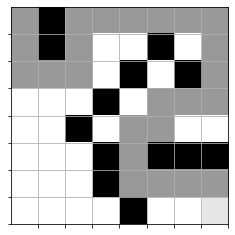

In [17]:
# File: Hickey_Dan_ProjectTwo.ipynb
# Author: Hickey, Dan
# Course: CS 370 - Current/Emerging Trends in Computer Science
# Instructor: Wilson, Kalysa
# Submission: 7-3 Project Two

#   Original code provided by Southern New Hampshire University
#   Student code solution is denoted

from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline

maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Exploration factor
epsilon = 0.1

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)

qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False
        
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

def qtrain(model, maze, **opt):

    # exploration factor
    global epsilon 

    # number of epochs
    n_epoch = opt.get('n_epoch', 15000)

    # maximum memory to store episodes
    max_memory = opt.get('max_memory', 1000)

    # maximum data size for training
    data_size = opt.get('data_size', 50)

    # start time
    start_time = datetime.datetime.now()

    # Construct environment/game from numpy array: maze (see above)
    qmaze = TreasureMaze(maze)

    # Initialize experience replay object
    experience = GameExperience(model, max_memory=max_memory)
    
    win_history = []   # history of win/lose game
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0
    
    # --- Student Solution Starts Here --- #
    
    # For each epooch, select free cell, reset maze and set agen to cell, set environment state
    for epoch in range(n_epoch):
        agent_cell = random.choice(qmaze.free_cells)
        qmaze.reset(agent_cell)
        envstate = qmaze.observe()
        
        # While state is running, process valid actions
        while qmaze.game_status() == 'not_over':
            valid_actions = qmaze.valid_actions()
            if not valid_actions:
                break
            
            # record current environment state
            prev_envstate = envstate  
        
            # Choose random valid direction/action, process result of action
            if np.random.rand() < epsilon:
                action = random.choice(valid_actions)
            else:
                action = np.argmax(experience.predict(prev_envstate))  

            envstate, reward, game_status = qmaze.act(action)
        
            # If game ends, append win history, else continue
            if game_status == 'win':
                win_history.append(1)
                game_over = True
            elif game_status == 'lose':
                win_history.append(0)
                game_over = True
            else:
                game_over = False
            
            # Record episode and store to experience replay
            episode = [prev_envstate, action, reward, envstate, game_over]
            experience.remember(episode)
            n_episodes = len(experience.memory)
        
            # Train neural network model and evaluate loss
            X, Y, = experience.get_data(data_size) 
            h = model.fit(
                X,
                Y,
                batch_size = 16,
                epochs = 8,
                verbose = 0
            )
            loss = model.evaluate(X, Y, verbose=0)
        
        # If the win rate is above threshold and model passes the completion check, that would be your epoch.
        if len(win_history) > hsize:
            win_rate = sum(win_history[-hsize:]) / hsize
            
    # --- Student Solution Ends Here --- #

    #Print the epoch, loss, episodes, win count, and win rate for each epoch
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
        # We simply check if training has exhausted all free cells and if in all
        # cases the agent won.
        if win_rate > 0.9 : epsilon = 0.05
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break
    
    
    # Determine the total time for training
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)

    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

qmaze = TreasureMaze(maze)
show(qmaze)

model = build_model(maze)
qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)

completion_check(model, qmaze)
show(qmaze)

pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)